# COMP8220 Machine Learning: Predicting Hair Colour
Jan Arvin Lapuz\
45758891

# Introduction

This notebook is for the major project submission for COMP8220 Machine Learning using the image dataset in the hair colour classification task. We use two different learning approaches to build models that accurately classifies the hair colour of a person in an image.

The notebook will be divided in the following sections:

*   a description of the selected conventional ML model;
*   some notes about the choices made in building the conventional ML model;
*   a description of the selected deep learning model;
*   some notes about the choices made in building the deep model; and
*   a discussion of the performance of the two models.



## Load the Relevant Packages and Import the Dataset

In [1]:
import os
from os.path import join
import random
import numpy as np
import pandas as pd
from google.colab import drive

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

from functools import partial

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [3]:
drive.mount('/content/drive/')

image_size = 48
hair_colours = ['black', 'blond', 'brown', 'gray']
dataset_directory = '/content/drive/My Drive/COMP8220 Machine Learning/celeba-guess-hair/image_dataset/'  ## CHANGE TO YOUR OWN DIRECTORY

images_train = np.load(join(dataset_directory, 'train_images.npy'))
labels_train = np.load(join(dataset_directory, 'train_labels.npy'))

images_val = np.load(join(dataset_directory, 'val_images.npy'))
labels_val = np.load(join(dataset_directory, 'val_labels.npy'))
files_val = np.load(join(dataset_directory, 'val_files.npy'))

images_test_public = np.load(join(dataset_directory, 'test_public_images.npy'))
files_test_public = np.load(join(dataset_directory, 'test_public_files.npy'))

images_train = images_train.reshape([-1, image_size, image_size, 3]) / 255.0
images_val = images_val.reshape([-1, image_size, image_size, 3]) / 255.0
images_test_public = images_test_public.reshape([-1, image_size, image_size, 3]) / 255.0

images_test_private = np.load(join(dataset_directory, 'test_private_images.npy'))
files_test_private = np.load(join(dataset_directory, 'test_private_files.npy'))

images_test_private = images_test_private.reshape([-1, image_size, image_size, 3]) / 255.0

print(images_train.shape)
print(images_val.shape)
print(images_test_public.shape)
print(images_test_private.shape)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
(98479, 48, 48, 3)
(12270, 48, 48, 3)
(11921, 48, 48, 3)
(13143, 48, 48, 3)


# Conventional Machine Learning Model

The first approach to the hair colour classification task is to develop conventional machine learning model discussed on the lectures.

## Final Conventional ML Model

The dataset is a set of images with each observation being a 2-dimensional (48 by 48) data with 3 channels (RGB). In order to use the information from these images, we need to flatten the data into a 1-dimensional array to use as input to the conventional machine learning algorithm. I defined a function to easily calculate the accuracy of the model that I have created. The final model is a Stochastic Gradient Descent (SGD) classifier achieving 80.75% accuracy on the public test set in Kaggle.

In [0]:
random_state = 42
train_final = images_train.reshape(images_train.shape[0],
                                   images_train.shape[1] * images_train.shape[2] * images_train.shape[3])
val_final = images_val.reshape(images_val.shape[0],
                               images_val.shape[1] * images_val.shape[2] * images_val.shape[3])
test_final = images_test_public.reshape(images_test_public.shape[0],
                                        images_test_public.shape[1] * images_test_public.shape[2] * images_test_public.shape[3])

In [5]:
print('Shape of training data :', train_final.shape)
print('Shape of validation data :', val_final.shape)
print('Shape of public testing data :', test_final.shape)

Shape of training data : (98479, 6912)
Shape of validation data : (12270, 6912)
Shape of public testing data : (11921, 6912)


In [0]:
def calculate_accuracy(conv, df_train, df_val):
  pred_train = conv.predict(df_train)
  pred_val = conv.predict(df_val)
  print('Train accuracy: ', accuracy_score(labels_train, pred_train))
  print('Validation accuracy: ', accuracy_score(labels_val, pred_val))

Once transformed into an 1-dimensional array, the number of features per image becomes 6,912 (48 x 48 x 3). This is an extremely large dataset and training it on the conventional machine learning algorithms can consume a lot of time so I also decided to try and reduce the number of features by using Principal Component Analysis (PCA). I applied the PCA transformation on both the training and validation data.

In [0]:
pca = PCA(n_components=0.95, random_state=random_state)
pca.fit(train_final)
pca_train = pca.transform(train_final)
pca_val = pca.transform(val_final)

In [10]:
print('Shape of training data after PCA:', pca_train.shape)
print('Shape of validation data after PCA:', pca_val.shape)

Shape of training data after PCA: (98479, 293)
Shape of validation data after PCA: (12270, 293)


Using PCA, I ended up with 293 features that explains 95% of the variation in the training dataset. That is almost a 96% reduction in the number of features. I performed two versions of the SGD classifier, one on the original data and one on the reduced data.

In [9]:
sgd_clf = SGDClassifier(random_state = random_state)
sgd_clf.fit(train_final, labels_train)

calculate_accuracy(sgd_clf, train_final, val_final)

Train accuracy:  0.8260644401344449
Validation accuracy:  0.7814180929095355


In [12]:
sgd_clf_pca = SGDClassifier(random_state = random_state)
sgd_clf_pca.fit(pca_train, labels_train)

calculate_accuracy(sgd_clf_pca, pca_train, pca_val)

Train accuracy:  0.774185359315184
Validation accuracy:  0.7484107579462103


Using the original dataset, the model achieved a training accuracy of 82.61% and a validation accuracy of 78.14%, while using the reduced dataset, the model achieved a training accuracy of 77.42% and a validation accuracy of 74.84%. Looking at the accuracies, I chose the model that uses the original dataset as my final conventional ML model.

## Notes on the Conventional ML Model

I have also tried creating several conventional machine learning classification models to improve the prediction accuracy. Some of the notable ones are below:

1. **K-Nearest Neighbors Classifier**

  I tried to run a Grid Search on the KNN algorithm to find the optimal k of the algorithm but it failed to converge due to the time and resource limitations of Colab.

2. **Bagging Classifier**
  * Using SGD Classifier

      I also explored on using ensemble learning methods by implementing the bagging classifier that uses the SGD classifier as predictor with 100 estimators and 1,000 samples per iteration on the original dataset. However, it only achieved 74.31% validation accuracy. The Bagging classifier with SGD on the reduced dataset only achieved 70.92% validation accuracy.

  * Using Linear SVM

      Another predictor that I used in Bagging is SVM with a linear kernel, regularization parameter of 1 and a hinge loss function trained on the original dataset. It only achieved 64.34% validation accuracy.

3. **Logistic Regression**

  One of the models that performed well is the logistic regression trained on the original data. It achieved 80.71% accuracy on the public test set. The main issue that I encountered when running logistic regression is that it executes slowly than the SGD classifier. Hence, this model was not picked as the final conventional ML model.

# Deep Learning Model

The second approach to the hair colour classification task is to develop a neural network from scratch. Helper functions are defined below to calculate and display accuracy and loss metrics for each model that is built.

In [0]:
input_shape = images_train.shape[1:]
num_classes = len(np.unique(labels_train))

def calculate_metrics(cnn):
  loss_train, accuracy_train = cnn.evaluate(images_train, labels_train, verbose=0)
  loss_val, accuracy_val = cnn.evaluate(images_val, labels_val, verbose=0)
  return loss_train, accuracy_train, loss_val, accuracy_val

def print_metrics(var):
  print('Train loss:', var[0])
  print('Train accuracy:', var[1])
  print('Validation loss:', var[2])
  print('Validation accuracy:', var[3])

## Final Deep Learning Model

I defined helper commands using the `partial` function for the Flatten, Dense, Convolution, Maxpooling, Dropout and Batch Normalization layers to easily build and specify my desired network architecture. Grid Search was performed using the number of hidden layers, number of neurons for each layer and activation function as the parameter set. I was limited by Colab's memory restrictions so I only selected those three parameters but given better resources, the number of convolution, maxpooling and dropout layers, dropout rate and learning rate can also be incorporated to the Grid Search algorithm. The code for Grid Search is left out on this notebook due to its long execution time but the optimal parameters found will be discussed further below.

In [0]:
Flatten_ = partial(keras.layers.Flatten)
Dense_ = partial(keras.layers.Dense, activation='relu', kernel_initializer='he_normal')
Conv_ = partial(keras.layers.Conv2D, kernel_size=(3, 3), activation='relu', padding='same')
Maxpool_ = partial(keras.layers.MaxPooling2D, pool_size=(2, 2), padding='same')
Dropout_ = partial(keras.layers.Dropout, rate=0.5)
BatchNorm_ = partial(keras.layers.BatchNormalization)

In [16]:
model_deep = keras.models.Sequential([
                Conv_(32, input_shape=input_shape),
                Conv_(32),
                Maxpool_(),
                Conv_(64),
                Conv_(64),
                Maxpool_(),
                Flatten_(),
                Dense_(512),
                Dropout_(),
                Dense_(512),
                Dropout_(),
                Dense_(512),
                Dropout_(),
                Dense_(num_classes, activation='softmax', kernel_initializer='glorot_uniform')
])

model_deep.compile(loss="sparse_categorical_crossentropy",
                   optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                   metrics=["accuracy"])

model_deep.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)             

Given the following parameter set for the Grid Search algorithm:

* no. of hidden layers: 1, 2, 3, 4, 5
* no. of neurons in each layer: 254, 512, 1024
* activation functions: ReLU, ELU, SELU

It was found that the optimal parameters are: 3 hidden layers with 512 neurons and ReLU as activation.

The final deep learning network is structured as follows:

1. **2 Convolution Layers with 32 filters each**

  Since I am working on small-sized images, I chose a small amount of filters to capture high-level features of the images. I also opted to use `padding='same'` to make sure that the features on the edge of the images are taken into account.

2. **Maxpooling Layer**
  
  Similar to the convolution layers, I chose to have `padding='same'` to capture features on the edge of the images.

3. **2 Convolution Layers with 64 filters each**

  I chose to increase the amount of filters on the second set of convolution layers to capture low-level features on the images. Again, `padding='same'` to capture features on the edge of the images.

4. **Maxpooling Layer**
5. **Hidden Layer with 512 neurons**
  
  I used the He initialization to address the unstable gradient problems the network might encounter. This is applicable to all Hidden layers of the network.

6. **Dropout Layer**
  
  I have manually explored different dropout rates in [0.3, 0.5, 0.7] and found that the optimal dropout rate is 0.5.

7. **Hidden Layer with 512 neurons**
8. **Dropout Layer**
9. **Hidden Layer with 512 neurons**
10. **Dropout Layer**
11. **Output Layer**
  
  The output layer contains four neurons corresponding to the four classes in the image dataset.

I used the `sparse_categorical_crossentropy` as the loss function and `Adam` optimizer with a learning rate of 0.0003.

In [17]:
history_deep = model_deep.fit(images_train, labels_train,
                              epochs = 100,
                              validation_data=(images_val, labels_val),
                              callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

history_deep = pd.DataFrame(history_deep.history)

Train on 98479 samples, validate on 12270 samples
Epoch 1/100
98479/98479 [==============================] - 31s 312us/step - loss: 0.4374 - accuracy: 0.8356 - val_loss: 0.2921 - val_accuracy: 0.8919
Epoch 2/100
98479/98479 [==============================] - 30s 310us/step - loss: 0.2800 - accuracy: 0.8994 - val_loss: 0.2564 - val_accuracy: 0.9064
Epoch 3/100
98479/98479 [==============================] - 31s 310us/step - loss: 0.2435 - accuracy: 0.9122 - val_loss: 0.2566 - val_accuracy: 0.9035
Epoch 4/100
98479/98479 [==============================] - 31s 311us/step - loss: 0.2153 - accuracy: 0.9230 - val_loss: 0.2657 - val_accuracy: 0.9065
Epoch 5/100
98479/98479 [==============================] - 31s 310us/step - loss: 0.1907 - accuracy: 0.9320 - val_loss: 0.2621 - val_accuracy: 0.9042
Epoch 6/100
98479/98479 [==============================] - 31s 311us/step - loss: 0.1658 - accuracy: 0.9412 - val_loss: 0.2642 - val_accuracy: 0.9086
Epoch 7/100
98479/98479 [=========================

In [18]:
metrics_deep = calculate_metrics(model_deep)
print_metrics(metrics_deep)

Train loss: 0.21575065806326035
Train accuracy: 0.9210288524627686
Validation loss: 0.25636405203045143
Validation accuracy: 0.9064384698867798


The deep learning model ran for 13 epochs. I specified an early stopping criteria to stop the training once there is no significant improvement in the validation loss. The network performs good with 92.10% training accuracy and 90.64% validation accuracy. However, the discrepancy in the training and validation accuracy suggests that the network is overfitted.

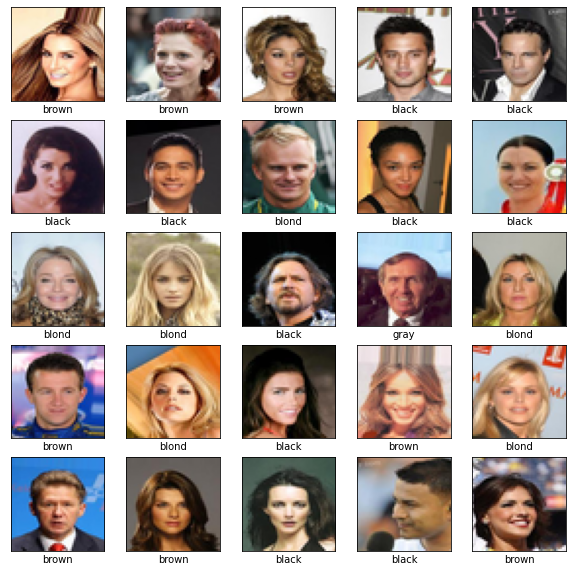

In [14]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(hair_colours[labels_train[i]])
plt.show()

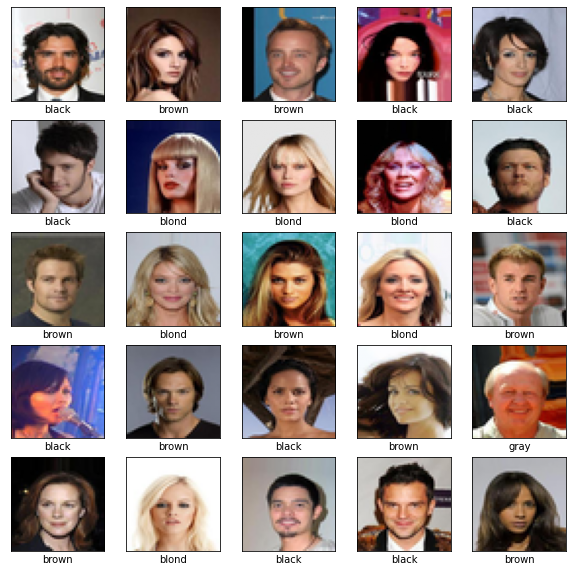

In [15]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_val[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(hair_colours[labels_val[i]])
plt.show()

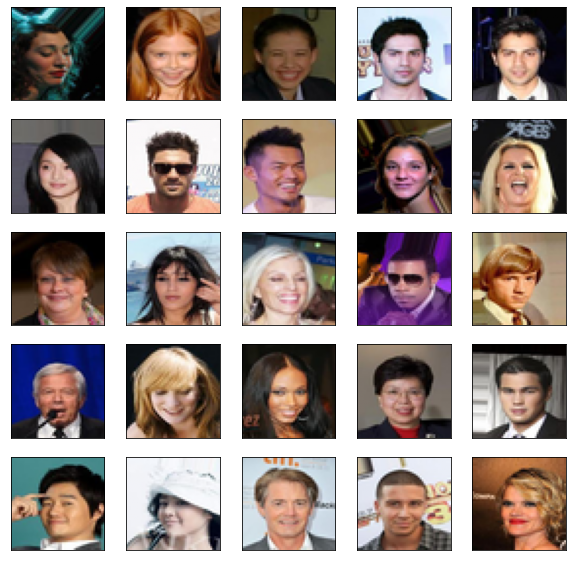

In [16]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_test_public[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    # plt.xlabel(hair_colours[labels_val[i]])
plt.show()

When I tried to visualize the training, validation and testing image sets, I noticed that some of the images were tranformed and so I performed data augmentation using `ImageDataGenerator` to create a new set of images based off of the original training image set and retrain the model on that data.

In [0]:
datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=(0.75, 1.25),
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
)
images_train_new = images_train
datagen.fit(images_train_new)

In [20]:
batch_size = 128
history_deep = model_deep.fit(datagen.flow(images_train_new, labels_train, batch_size),
                              steps_per_epoch=len(images_train_new) / batch_size, epochs=100,
                              validation_data=(images_val, labels_val),
                              callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

history_deep = pd.DataFrame(history_deep.history)

Epoch 1/100
770/769 [==============================] - 88s 114ms/step - loss: 0.4772 - accuracy: 0.8236 - val_loss: 0.3869 - val_accuracy: 0.8589
Epoch 2/100
770/769 [==============================] - 87s 113ms/step - loss: 0.3817 - accuracy: 0.8607 - val_loss: 0.2839 - val_accuracy: 0.8916
Epoch 3/100
770/769 [==============================] - 87s 113ms/step - loss: 0.3483 - accuracy: 0.8720 - val_loss: 0.2833 - val_accuracy: 0.8982
Epoch 4/100
770/769 [==============================] - 87s 113ms/step - loss: 0.3371 - accuracy: 0.8774 - val_loss: 0.3023 - val_accuracy: 0.8837
Epoch 5/100
770/769 [==============================] - 87s 113ms/step - loss: 0.3235 - accuracy: 0.8824 - val_loss: 0.2716 - val_accuracy: 0.8993
Epoch 6/100
770/769 [==============================] - 87s 113ms/step - loss: 0.3146 - accuracy: 0.8863 - val_loss: 0.2810 - val_accuracy: 0.8919
Epoch 7/100
770/769 [==============================] - 87s 113ms/step - loss: 0.3031 - accuracy: 0.8895 - val_loss: 0.3137 -

In [21]:
metrics_deep = calculate_metrics(model_deep)
print_metrics(metrics_deep)

Train loss: 0.19477793100329824
Train accuracy: 0.9281572699546814
Validation loss: 0.22707275185724926
Validation accuracy: 0.9154849052429199


The final model created above achieves a training accuracy of 92.82% and a validation accuracy of 91.55%. It has also achieved a testing accuracy of 93.11% on the public test set in the Kaggle competition.

## Notes on the Deep Learning Model

I have also created several networks, each with varying depth and complexity as an attempt to improve the prediction accuracy. Some of the notable ones are below.

1. **Simple Neural Network**

  This is the baseline network that I created where I run my Grid Search algorithm. It contains 3 hidden layers with 512 neurons each and ReLU as activation function, and the output layer. It achieved a training accuracy of 89.05% and validation accuracy of 85.94% which suggests overfitting. While the training and validation accuracy are relatively low compared to the final deep learning network, this baseline network served as the foundation of the networks that I have explored.

2. **Network with Batch Normalization**

  I have tried different regularization components in the networks and one of them is batch normalization. The network has the same parameters as the Simple Neural Network in 1 but with Batch Normalization Layers in between the Hidden Layers. It achieved a 90.00% training accuracy and 84.93% validation accuracy which, again, suggests overfitting. The result of this network is not far from the accuracy in 1 and so I opted for Dropout Layers instead as regularization in my network.

3. **Network with 2 Conv + Pool Layers**

  During my exploration of the parameters of CNN, one of the better models was the one with 2 Convolution + Maxpooling layers, 3 Hidden Layers with Dropout Layers in between. Similar to the final model, the first Convolution Layer has 32 filters while the second has 64 filters and the dropout rate is 0.5. It achieved a training accuracy of 94.55% and a validation accuracy of 91.04%. The high validation accuracy makes it one of the choices for the final model, however, upon retraining the network on the augmented data (as performed above on the final model), the training accuracy was reduced to 93.13% and the validation accuracy improved slightly to 91.22%. Overfitting is still an issue on this network.


# Discussion of Model Performance and Implementation

Comparing my final conventional machine learning and deep learning models, the deep learning model performed better by 12.36% on the public test set. The deep learning model ranked 10 out of 56 submissions on the public test set, with the top-performing system having 93.94% accuracy, and a majority class baseline having 89.71% accuracy. It ranked 16 out of 49 submissions on the private test set, with the top-performing system having 66.13% accuracy.

The validation accuracy is generally lower than the training accuracy and the public test accuracy on both the conventional machine learning model and the deep learning model. I can think of two reasons that can lead to this. First is that the validation set is not a good representation of the overall image data, i.e., there might have been an issue when splitting the training, validation and testing datasets. This can be rectified by combining the training and validation data and splitting them again. The second reason is that the values of the hyperparameters may not be optimal for the network. In this case, Grid Search or Randomized Search with cross-validation may be performed on the training set to find the best set of parameters for the network.

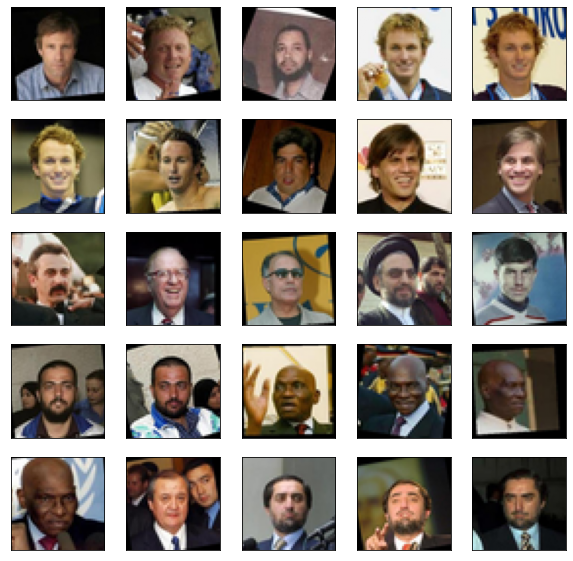

In [18]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_test_private[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    # plt.xlabel(hair_colours[labels_val[i]])
plt.show()

There is a significant drop in the public test accuracy (93.11%) and the private test accuracy (62.81%). Looking at the first 25 images on the private test set above, it can be observed that most of the images were in some way transformed or translated from its original version (e.g. rotated or shifted to the left/right). This could have been addressed by the data augmentation process that I performed on my deep learning network, however, it looks like when the images were transformed, it was on a black background. I believe that if I trained my network on the data augmentation where the parameter is `fill='constant'`, it would have gotten a slightly higher accuracy. There are also images of individuals that do not have hair which my network was not trained to detect. This also could have been a factor for the network performing poorly on the private test set.

Training a network is not an easy task as there are many tunable parameters to consider. There are existing methods that can be used to find the optimal parameters of a network given a particular task as mentioned above: the Grid Search and Randomized Search algorithms. While there is an attempt to perform Grid Search in my analysis, it is extremely time-consuming and given the resource limitations of Colab, I had to stop at three parameter sets (number of hidden layers, number of neurons per layer and optimizer). Provided with a more powerful machine, hyperparameter tuning can be performed more efficiently to have a more robust model for prediction.